# Usage

First load the necessary libraries:

In [1]:
import miditapyr as mt
import mido
import pandas
import altair as alt
from rpy2.robjects import pandas2ri, r

pandas2ri.activate()


In order to run R, (we'll also use the R packages [pyramidi](https://github.com/urswilke/pyramidi) and the [tidyverse](https://www.tidyverse.org/)) in this jupyter notebook (via the cell magic **%%R**), the python package rpy2 needs to be used:

In [2]:
%load_ext rpy2.ipython 

In [23]:
%%R
library(tidyverse)
library(pyramidi)

## Load midi file

There is a small test [midi file included in this package](https://github.com/urswilke/miditapyr/raw/master/notebooks/test_midi_file.mid):

In [4]:
mt.get_test_midi_file()

<midi file '/home/chief/anaconda3/lib/python3.8/site-packages/miditapyr/data/test_midi_file.mid' type 1, 3 tracks, 268 messages>

This file comes shipped when you install the package. You can also get the same result by specifying `as_string=True`

In [5]:
mid_file_str = mt.get_test_midi_file(as_string=True)
mid_file_str

'/home/chief/anaconda3/lib/python3.8/site-packages/miditapyr/data/test_midi_file.mid'

and then loading it with `mido`

In [6]:
mido_mid_file = mido.MidiFile(mid_file_str)

Here you can listen to the midi file converted to mp3:

In [34]:
import IPython
IPython.display.Audio(url = "https://raw.githubusercontent.com/urswilke/miditapyr/master/docs/source/notebooks/test_midi_file.mp3")

## Midi to dataframe

Now the midi data can be loaded in a dataframe `dfc` and an integer `ticks_per_beat`:

In [8]:
dfc = mt.midi_to_df(mido_mid_file)
ticks_per_beat = mido_mid_file.ticks_per_beat

dfc


,i_track,meta,msg
0,0,True,"{'type': 'track_name', 'name': 'drum-t1-1-t1',..."
1,0,False,"{'type': 'note_on', 'time': 0, 'note': 43, 've..."
2,0,False,"{'type': 'note_on', 'time': 0, 'note': 39, 've..."
3,0,False,"{'type': 'note_on', 'time': 0, 'note': 36, 've..."
4,0,True,"{'type': 'set_tempo', 'tempo': 666666, 'time': 0}"
...,...,...,...
263,2,False,"{'type': 'note_off', 'time': 31, 'note': 59, '..."
264,2,False,"{'type': 'note_off', 'time': 9, 'note': 67, 'v..."
265,2,False,"{'type': 'note_on', 'time': 266, 'note': 62, '..."
266,2,False,"{'type': 'note_off', 'time': 5, 'note': 62, 'v..."


In [9]:
ticks_per_beat

960

This dataframe `dfc` consists of 3 columns:

Column name | Meaning
----------- | -------
**i_track** |  the track number
**meta** |     whether the event in 'msg' is a [mido meta event](https://mido.readthedocs.io/en/latest/midi_files.html#meta-messages)
**msg**  |   the (meta) event information read by [mido.MidiFile()](https://mido.readthedocs.io/en/latest/midi_files.html) in a list of dictionaries


The information in the midi events in the `msg` column consists of keyword - value pairs. You can transform this information to a wide format with `mt.tidy_df()`. Now every keyword gets its own column:

In [10]:
df = mt.tidy_df(dfc)
df

,i_track,meta,type,name,time,note,velocity,channel,tempo,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat
0,0,True,track_name,drum-t1-1-t1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,False,note_on,NaN,0,43.0,72.0,9.0,NaN,NaN,NaN,NaN,NaN
2,0,False,note_on,NaN,0,39.0,64.0,9.0,NaN,NaN,NaN,NaN,NaN
3,0,False,note_on,NaN,0,36.0,101.0,9.0,NaN,NaN,NaN,NaN,NaN
4,0,True,set_tempo,NaN,0,NaN,NaN,NaN,666666.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,2,False,note_off,NaN,31,59.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN
264,2,False,note_off,NaN,9,67.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN
265,2,False,note_on,NaN,266,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN
266,2,False,note_off,NaN,5,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN


Now we are ready to run R code. We'll import the objects `df` and `ticks_per_beat` to R. The function `tab_measures()` [translates the time information](https://urswilke.github.io/pyramidi/reference/tab_measures.html) in the midi file (measured in ticks between events) to absolute times and also translates it to seconds (`t`), measures (`m`) and beats (`b`):

In [11]:
%%R -i df -i ticks_per_beat

dfm <- tab_measures(df, ticks_per_beat)
head(dfm)

  i_track meta           type         name time note velocity channel  tempo
1       0    1     track_name drum-t1-1-t1    0  NaN      NaN     NaN    NaN
2       0    0        note_on         <NA>    0   43       72       9    NaN
3       0    0        note_on         <NA>    0   39       64       9    NaN
4       0    0        note_on         <NA>    0   36      101       9    NaN
5       0    1      set_tempo         <NA>    0  NaN      NaN     NaN 666666
6       0    1 time_signature         <NA>    0  NaN      NaN     NaN    NaN
  numerator denominator clocks_per_click notated_32nd_notes_per_beat ticks t m
1       NaN         NaN              NaN                         NaN     0 0 0
2       NaN         NaN              NaN                         NaN     0 0 0
3       NaN         NaN              NaN                         NaN     0 0 0
4       NaN         NaN              NaN                         NaN     0 0 0
5       NaN         NaN              NaN                         N

/home/chief/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "name". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'rpy2.rinterface_lib.sexp.NACharacterType'>).
  warnings.warn('Error while trying to convert '


 i_note
1 0      0
2 0      1
3 0      1
4 0      1
5 0      0
6 0      0


Now we'll import this dataframe `dfm` back to python:

In [12]:
dfm = r['dfm']
dfm

,i_track,meta,type,name,time,note,velocity,channel,tempo,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,ticks,t,m,b,i_note
1,0,1,track_name,drum-t1-1-t1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,0
2,0,0,note_on,NA_character_,0,43.0,72.0,9.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,1
3,0,0,note_on,NA_character_,0,39.0,64.0,9.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,1
4,0,0,note_on,NA_character_,0,36.0,101.0,9.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,1
5,0,1,set_tempo,NA_character_,0,NaN,NaN,NaN,666666.0,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2,0,note_off,NA_character_,31,59.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN,15080,10.472212,15.708333,62.833333,4
265,2,0,note_off,NA_character_,9,67.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN,15089,10.478462,15.717708,62.870833,4
266,2,0,note_on,NA_character_,266,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN,15355,10.663184,15.994792,63.979167,14
267,2,0,note_off,NA_character_,5,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN,15360,10.666656,16.000000,64.000000,14


As there are conversion problems of some columns we'll transform `meta` back to a boolean:

In [13]:

dfm['meta'] = dfm['meta'].astype(bool)

dfm

,i_track,meta,type,name,time,note,velocity,channel,tempo,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat,ticks,t,m,b,i_note
1,0,True,track_name,drum-t1-1-t1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,0
2,0,False,note_on,NA_character_,0,43.0,72.0,9.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,1
3,0,False,note_on,NA_character_,0,39.0,64.0,9.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,1
4,0,False,note_on,NA_character_,0,36.0,101.0,9.0,NaN,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,1
5,0,True,set_tempo,NA_character_,0,NaN,NaN,NaN,666666.0,NaN,NaN,NaN,NaN,0,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2,False,note_off,NA_character_,31,59.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN,15080,10.472212,15.708333,62.833333,4
265,2,False,note_off,NA_character_,9,67.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN,15089,10.478462,15.717708,62.870833,4
266,2,False,note_on,NA_character_,266,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN,15355,10.663184,15.994792,63.979167,14
267,2,False,note_off,NA_character_,5,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN,15360,10.666656,16.000000,64.000000,14


and split the dataframe in two by whether events are meta or not:

In [14]:
df_meta, df_notes = mt.split_df(dfm)


Now we'll import these back to R and [transform the data to a wide format](https://urswilke.github.io/pyramidi/reference/widen_events.html) with `widen_events()`:

In [15]:
%%R -i df_notes -i df_meta -i df

df_not_notes <- df_notes %>% 
  filter(!str_detect(.data$type, "^note_o[nf]f?$")) 

df_notes_wide <- df_notes %>% 
  filter(str_detect(.data$type, "^note_o[nf]f?$")) %>%
  widen_events() %>%
  left_join(midi_defs)




Joining, by = "note"


/home/chief/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "name". Fall back to string conversion. The error is: <class 'rpy2.rinterface_lib.sexp.NACharacterType'>
  warnings.warn('Error while trying to convert '
/home/chief/anaconda3/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "name". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'rpy2.rinterface_lib.sexp.NACharacterType'>).
  warnings.warn('Error while trying to convert '


Now we can visualize the note events as piano roll plots for all tracks in the midi file:

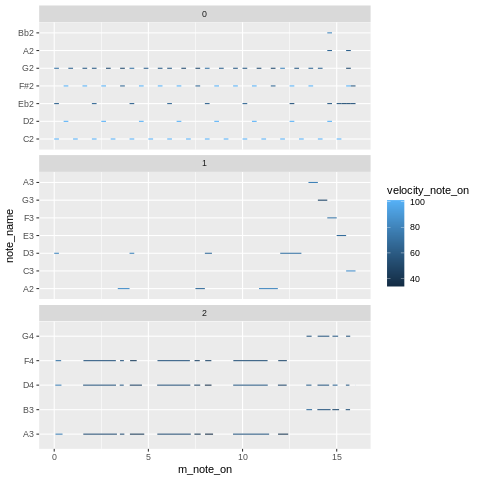

In [16]:
%%R
p1 <- df_notes_wide %>%
  ggplot() +
  geom_segment(
    aes(
      x = m_note_on,
      y = note_name,
      xend = m_note_off,
      yend = note_name,
      color = velocity_note_on
    )
  ) +
  # each midi track is printed into its own facet:
  facet_wrap( ~ i_track,
              ncol = 1,
              scales = "free_y")
p1


We can also visualize a piano roll of the midi data in `df_notes_wide` with altair.  We'll drop the name column as there were some more conversion problems:

In [17]:
df_notes_wide = r['df_notes_wide']
df_notes_wide.drop('name', axis=1)


,i_track,meta,note,channel,i_note,time_note_on,time_note_off,velocity_note_on,velocity_note_off,ticks_note_on,ticks_note_off,t_note_on,t_note_off,m_note_on,m_note_off,b_note_on,b_note_off,note_name
1,0,0,43.0,9.0,1,0,240,72.0,72.0,0,240,0.000000,0.166666,0.000000,0.250000,0.000000,1.000000,G2
2,0,0,39.0,9.0,1,0,0,64.0,64.0,0,240,0.000000,0.166666,0.000000,0.250000,0.000000,1.000000,Eb2
3,0,0,36.0,9.0,1,0,0,101.0,101.0,0,240,0.000000,0.166666,0.000000,0.250000,0.000000,1.000000,C2
4,0,0,42.0,9.0,1,240,0,101.0,101.0,480,720,0.333333,0.500000,0.500000,0.750000,2.000000,3.000000,F#2
5,0,0,38.0,9.0,1,0,0,101.0,101.0,480,720,0.333333,0.500000,0.500000,0.750000,2.000000,3.000000,D2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2,0,62.0,15.0,12,8,251,65.0,65.0,14191,14442,9.854851,10.029157,14.782292,15.043750,59.129167,60.175000,D4
127,2,0,59.0,15.0,4,337,31,57.0,57.0,14859,15080,10.318740,10.472212,15.478125,15.708333,61.912500,62.833333,B3
128,2,0,62.0,15.0,13,9,173,60.0,60.0,14868,15049,10.324990,10.450684,15.487500,15.676042,61.950000,62.704167,D4
129,2,0,67.0,15.0,4,8,9,57.0,57.0,14876,15089,10.330545,10.478462,15.495833,15.717708,61.983333,62.870833,G4


In [18]:
df_subset = df_notes_wide[['m_note_on', 'm_note_off', 'velocity_note_on', 'note', 'i_track']]

alt.Chart(df_subset).mark_bar().encode(
    x='m_note_on:T',
    x2='m_note_off:T',
    y='note:N',
    color='velocity_note_on:Q',
    tooltip=['m_note_on', 'm_note_off', 'note']
).properties(
    width=200,
    height=200
).facet(
    facet='i_track:O',
    columns=1
).resolve_scale(
    y='independent'
).interactive()


alt.FacetChart(...)

Now we'll go back to R and convert the dataframe back to a long format:

In [19]:
%%R

df_notes_out <- df_notes_wide %>%
  select(
    c("i_track", "channel", "note", "i_note"), 
    matches("_note_o[nf]f?$")
  ) %>%
  pivot_longer(
    matches("_note_o[nf]f?$"),
    names_to = c(".value", "type"),
    names_pattern = "(.+?)_(.*)"
  ) %>% 
  mutate(meta = FALSE) 


df_notes_out <-
  df_notes_out %>%
  full_join(df_meta) %>% 
  full_join(df_not_notes) %>%
  arrange(i_track, ticks) %>% 
  group_by(i_track) %>%
  mutate(time = ticks - lag(ticks) %>% {.[1] = 0; .}) %>%
  ungroup()




df2 <- 
  df_notes_out %>% 
  select(names(df)) %>% 
  # mutate_if(is_numeric, as.integer) %>% 
  mutate_if(is.numeric, ~ifelse(is.na(.), NaN, .))

Joining, by = c("i_track", "i_note", "type", "time", "ticks", "t", "m", "b", "meta")
Joining, by = c("i_track", "channel", "note", "i_note", "type", "time", "velocity", "ticks", "t", "m", "b", "meta", "name")


In [20]:
df2 = r['df2']
df2['meta'] = df2['meta'].astype(bool)

df2.drop('name', axis=1, inplace = True)
df2

,i_track,meta,type,time,note,velocity,channel,tempo,numerator,denominator,clocks_per_click,notated_32nd_notes_per_beat
1,0,False,note_on,0.0,43.0,72.0,9.0,NaN,NaN,NaN,NaN,NaN
2,0,False,note_on,0.0,39.0,64.0,9.0,NaN,NaN,NaN,NaN,NaN
3,0,False,note_on,0.0,36.0,101.0,9.0,NaN,NaN,NaN,NaN,NaN
4,0,True,track_name,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,True,set_tempo,0.0,NaN,NaN,NaN,666666.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
264,2,False,note_off,31.0,59.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN
265,2,False,note_off,9.0,67.0,57.0,15.0,NaN,NaN,NaN,NaN,NaN
266,2,False,note_on,266.0,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN
267,2,False,note_off,5.0,62.0,82.0,15.0,NaN,NaN,NaN,NaN,NaN


In [21]:
dfc2 = mt.compact_df(df2, repair_reticulate_conversion = True)
dfc2


,i_track,meta,msg
0,0,False,"{'type': 'note_on', 'time': 0, 'note': 43, 've..."
1,0,False,"{'type': 'note_on', 'time': 0, 'note': 39, 've..."
2,0,False,"{'type': 'note_on', 'time': 0, 'note': 36, 've..."
3,0,True,"{'type': 'track_name', 'time': 0}"
4,0,True,"{'type': 'set_tempo', 'time': 0, 'tempo': 666666}"
...,...,...,...
263,2,False,"{'type': 'note_off', 'time': 31, 'note': 59, '..."
264,2,False,"{'type': 'note_off', 'time': 9, 'note': 67, 'v..."
265,2,False,"{'type': 'note_on', 'time': 266, 'note': 62, '..."
266,2,False,"{'type': 'note_off', 'time': 5, 'note': 62, 'v..."


We can save the midi data back to a file:

In [22]:
mt.df_to_midi(dfc2,
              ticks_per_beat,
              "test.mid")